In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from numpy import arange, quantile
from numpy.random import randint, permutation

# Scalar Qunatiles via Optimal Transport

In [14]:
# Data
np.random.seed(42)

T = 100
N = 1000
Y = np.random.randn(N)[:, None]  # permutation(arange(start=0.0, stop=10.0, step=10/N))

U = 1 / T * (np.arange(0, T) + 1)

In [13]:
D = np.zeros([T, T])
D[1:, :] = -np.eye(T - 1, T)
D[:, :] += np.eye(T)
Dinv = np.linalg.inv(D)

one_N = np.ones([N, 1])
one_T = np.ones([T, 1])
Pi_cp = cp.Variable(shape=(T, N))

In [6]:
# Problem definition
objective = U.T @ Pi_cp @ Y
constraints = [
    Pi_cp @ one_N == 1 / T * one_T,
    Pi_cp >= 0,
    one_T.T @ Pi_cp == 1 / N * one_N.T,
]

problem = cp.Problem(objective=cp.Maximize(objective), constraints=constraints)
problem.solve(verbose=True,)
quantiles = D @ constraints[0].dual_value * T  # Figure out why scaling is required
gt = quantile(Y.squeeze(), q=U.squeeze())

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jun 30 02:58:46 PM: Your problem has 100000 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 30 02:58:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 02:58:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 30 02:58:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 30 02:58:46 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 30 02:58:46 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

Text(0.5, 1.0, 'Pi')

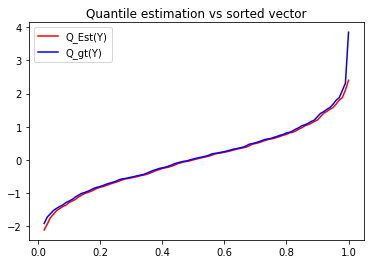

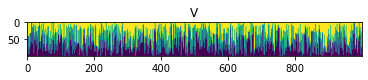

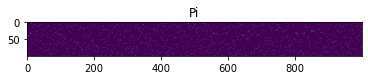

In [10]:
plt.figure()
plt.plot(U[1:], quantiles.squeeze()[1:], "r")
plt.plot(U[1:], gt[1:], "b")
plt.title("Quantile estimation vs sorted vector")
plt.legend(["Q_Est(Y)", "Q_gt(Y)"])

V = Dinv.T @ Pi_cp.value

plt.figure()
plt.imshow(V)
plt.title("V")
# plt.colorbar()


plt.figure()
plt.imshow(Pi_cp.value)
plt.title("Pi")
# plt.colorbar()

# Vector Quantiles

In [117]:
# Data
np.random.seed(42)

d = 2
T = 25
N = 500
# Y = np.random.randn(N, d)
rho = 0.9
Y = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]], size=(N,))

u = 1 / T * (np.arange(0, T) + 1)
U1, U2 = np.meshgrid(*([u,]*d)) # not handling d>2
U = np.stack([U1.reshape(-1), U2.reshape(-1)], axis=1)

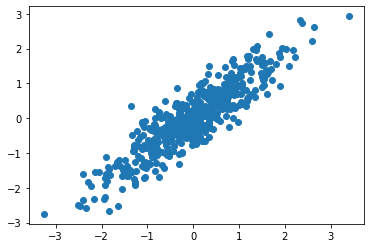

In [118]:
plt.scatter(Y[:, 0], Y[:, 1])

In [119]:
from scipy.spatial.distance import cdist

# Pairwise distances (similarity)
S = cdist(U, Y, metric="euclidean")
S.shape

(625, 500)

In [120]:
Td = T ** d

D = np.zeros([Td, Td])
D[1:, :] = -np.eye(Td - 1, Td)
D[:, :] += np.eye(Td)
Dinv = np.linalg.inv(D)

one_N = np.ones([N, d])
one_T = np.ones([Td, d])
Pi_cp = cp.Variable(shape=(Td, N))

In [121]:
# Problem definition

objective = cp.sum(cp.multiply(Pi_cp, S))

constraints = [
    Pi_cp @ one_N == 1 / Td * one_T,
    Pi_cp >= 0,
    one_T.T @ Pi_cp == 1 / N * one_N.T,
]

problem = cp.Problem(objective=cp.Maximize(objective), constraints=constraints)
problem.solve(verbose=True,)
quantiles = D @ constraints[0].dual_value * Td  # Figure out why scaling is required
gt = quantile(Y.squeeze(), q=U.squeeze())

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jun 30 03:55:22 PM: Your problem has 312500 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 30 03:55:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 03:55:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 30 03:55:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 30 03:55:22 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 30 03:55:22 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

In [122]:
quantiles.shape

(625, 2)

<ipython-input-123-859f9b32f71b>:6: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax[i].plot_surface(U1, U2, Q)


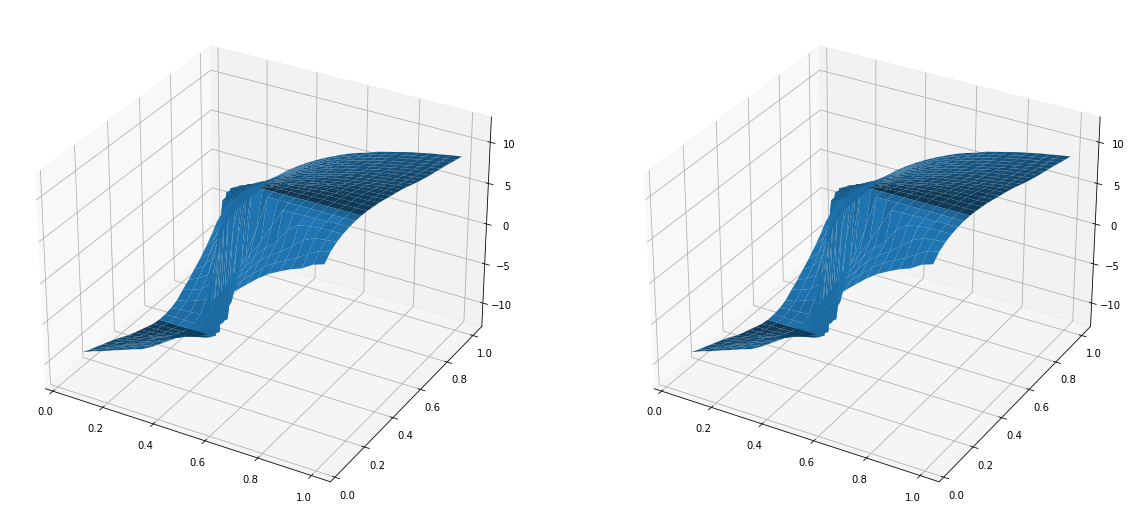

In [123]:
fig, ax = plt.subplots(1, d, figsize=(20, 10), subplot_kw={"projection": "3d"})

for i in range(d):
    Q = quantiles[:, i].reshape(T, T)
    Q[:, 0] = np.nan
    ax[i].plot_surface(U1, U2, Q)

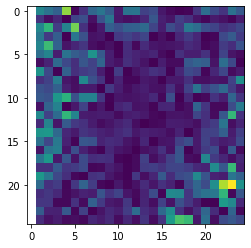

In [124]:
Q_ = np.abs(quantiles[:, 0].reshape(T, T) - quantiles[:, 1].reshape(T, T))
Q_[:,0] = np.nan
plt.imshow(Q_)

In [125]:
import itertools as it

Q1 = quantiles[:, 0].reshape(T, T)
Q2 = quantiles[:, 1].reshape(T, T)

for i0, j0 in it.product(range(1, T), range(1, T)):
    
    u0 = np.array([U1[i0, j0], U2[i0, j0]])
    q0 = np.array([Q1[i0, j0], Q2[i0, j0]])
    
    for i1, j1 in it.product(range(1, T), range(1, T)):

        u1 = np.array([U1[i1, j1], U2[i1, j1]])
        q1 = np.array([Q1[i1, j1], Q2[i1, j1]])
    
        assert np.dot(q1-q0, u1-u0) >= 0, (i0, j0, i1, j1)

AssertionError: (1, 1, 2, 1)

In [126]:
np.dot(q1-q0, u1-u0)

-0.013345126806367487